#  Previous Training

## Vivado design

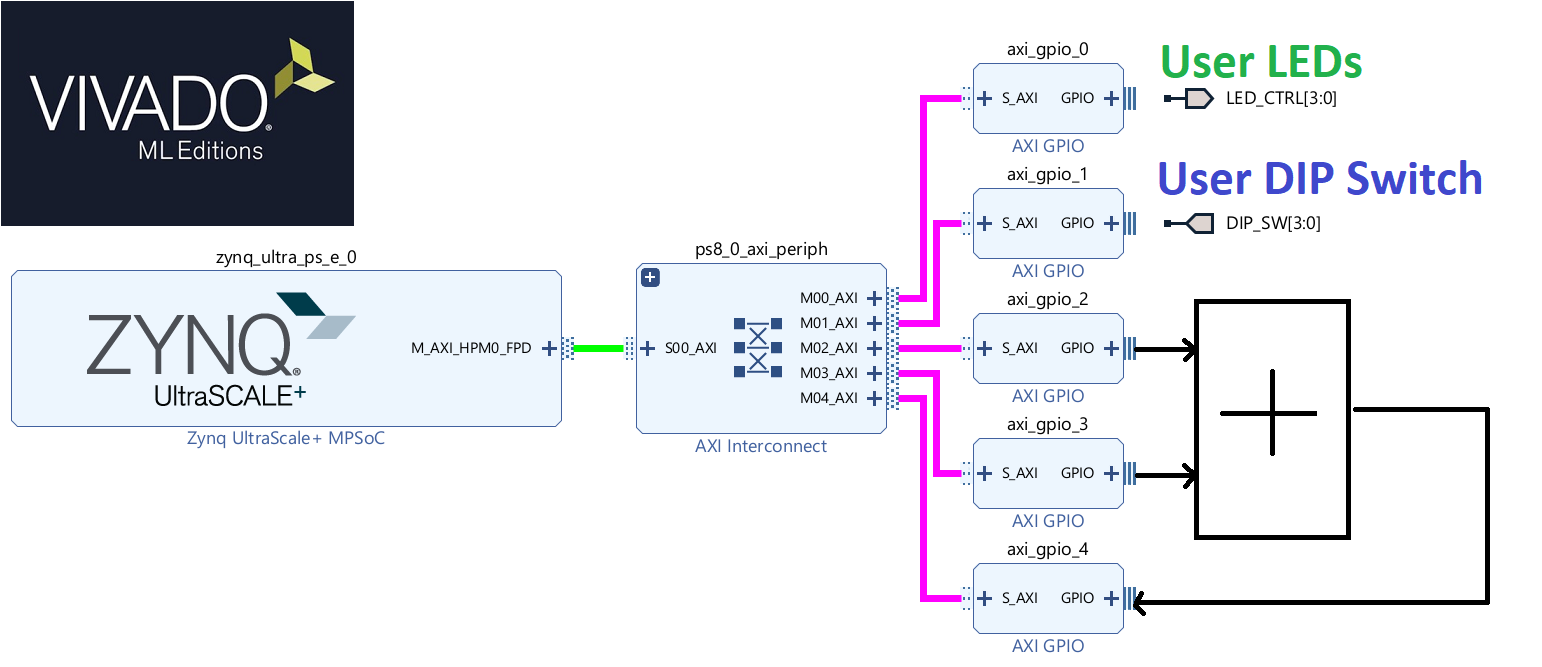

## Vitis design

### Xil_In
### Xil_Out
### Volatile Pointer

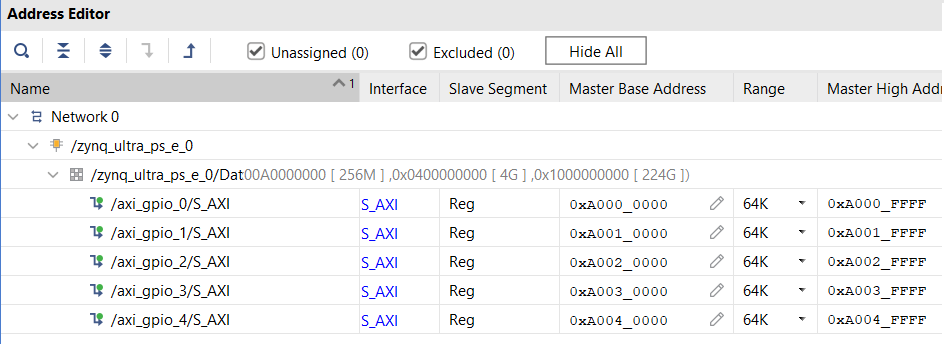

In [2]:
# Various modules are imported
from pynq import Overlay
from pynq.lib import AxiGPIO
from pynq import MMIO
import time

In [8]:
# Probram the PL with the provided bitstream
# utilizes the .hwh file to initialize and configure all required PYNQ 
ol = Overlay("design_1.bit")

In [9]:
# Exploring the Overlay Attributes
ol?

In [10]:
# Define an AXI GPIO object
# The read() and write() methods are used to read and write data on a channel (all of the GPIO).
led_ip = ol.axi_gpio_0

## Address Space Offset 
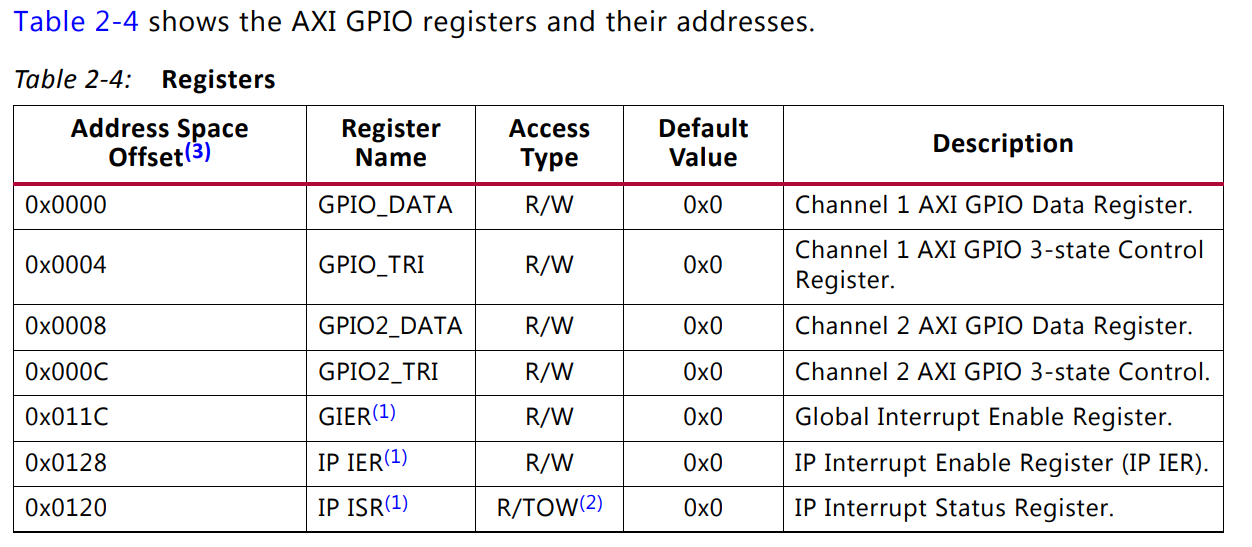

In [11]:
#  Offset: The address offset of the GPIO register.
ADDRESS_OFFSET = 0

#  Value: The data to be written.
Value = 0x03
# turn on first two LEDs
led_ip.write(ADDRESS_OFFSET,Value)

In [15]:
# Read DIP Switch Value with AXI GPIO Class
dip_sw_ip = ol.axi_gpio_1
read_value = dip_sw_ip.read(ADDRESS_OFFSET)
print("DIP Switch mode:",read_value)

DIP Switch mode: 0


In [16]:
# AXI GPIO 0 base address
AXI_GPIO_0_BASE_ADDRESS = 0xA0000000

# AXI GPIO 1 base address
AXI_GPIO_1_BASE_ADDRESS = 0xA0010000

# AXI GPIO 2 base address
AXI_GPIO_2_BASE_ADDRESS = 0xA0020000

# AXI GPIO 3 base address
AXI_GPIO_3_BASE_ADDRESS = 0xA0030000

# AXI GPIO 4 base address
AXI_GPIO_4_BASE_ADDRESS = 0xA0040000

# Address range 
ADDRESS_RANGE = 64000

In [17]:
# MMIO Object to control AXI GPIO 0
gpio_leds = MMIO(AXI_GPIO_0_BASE_ADDRESS, ADDRESS_RANGE)

# MMIO Object to control AXI GPIO 1
gpio_dips  = MMIO(AXI_GPIO_1_BASE_ADDRESS, ADDRESS_RANGE)

# MMIO Object to control AXI GPIO 2
AXI_GPIO_2_mmio = MMIO(AXI_GPIO_2_BASE_ADDRESS, ADDRESS_RANGE)

# MMIO Object to control AXI GPIO 3
AXI_GPIO_3_mmio = MMIO(AXI_GPIO_3_BASE_ADDRESS, ADDRESS_RANGE)

# MMIO Object to control AXI GPIO 4
AXI_GPIO_4_mmio = MMIO(AXI_GPIO_4_BASE_ADDRESS, ADDRESS_RANGE)

In [18]:
# send values to the Adder implemented in the PL and read back the result
for i in range(3):
    
    # write value to AXI GPIO 2
    inp_1 = 2*i
    AXI_GPIO_2_mmio.write(ADDRESS_OFFSET,inp_1)
    
    # write value to AXI GPIO 3
    inp_2 = 3*i
    AXI_GPIO_3_mmio.write(ADDRESS_OFFSET,inp_2)
    
    # read the AXI GPIO4 
    results_out = AXI_GPIO_4_mmio.read(ADDRESS_OFFSET)
    
    print(inp_1 , " + ", inp_2, " = ", results_out)
    

0  +  0  =  0
2  +  3  =  5
4  +  6  =  10


#  Control the User I/O with MMIO
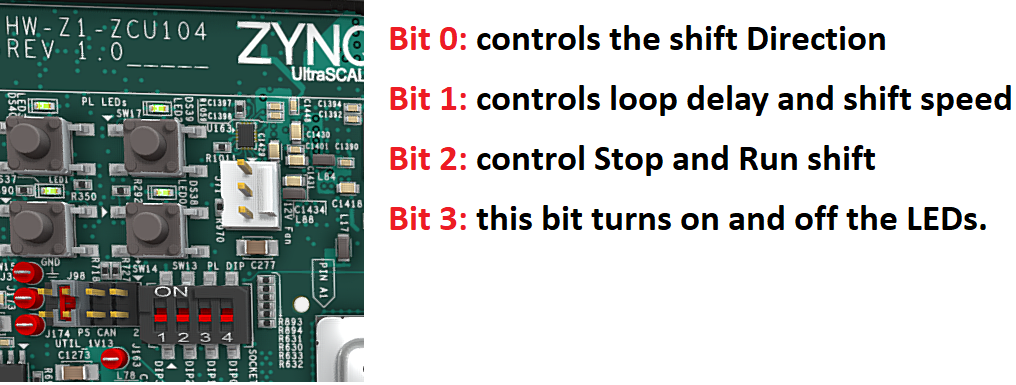

In [ ]:
# Initialize variables
init_shift_value = 0b0001
LED_Shiffer_Value = init_shift_value & 0b1111
shift_direction = 1  # 1 for right, 0 for left
usecond_sleep = 125000 / 1e6  # Convert microseconds to seconds for Python's sleep
stop_shift = 0  # Will stop the shift if this is 1
off_leds = 0  # Turn off all LEDs if this value is 1

# Track the previous DIP switch value
previous_dip_switch_value = -1  # Start with an invalid value to ensure it prints the first time

for i in range(10000):
    # Write the value to the User LEDs
    if off_leds == 0:
        gpio_leds.write(0x00, LED_Shiffer_Value)
    else:
        gpio_leds.write(0x00, 0)

    # Delay in the loop (in seconds)
    time.sleep(usecond_sleep)

    # Read the User DIP switch in polled mode
    dip_switch_value = gpio_dips.read(0x00) & 0b1111

    # If the DIP switch value changes, print the new value
    if dip_switch_value != previous_dip_switch_value:
        print(f"New DIP switch value: {bin(dip_switch_value)}")
        previous_dip_switch_value = dip_switch_value  # Update the tracked value

    # Update parameters based on the DIP switch value
    shift_direction = dip_switch_value & 0b0001  # First bit controls the direction
    usecond_sleep = 125000 * (1 if (dip_switch_value & 0b0010) == 0 else 2) / 1e6  # Second bit controls the speed
    stop_shift = (dip_switch_value & 0b0100)  # Third bit to stop or run
    off_leds = (dip_switch_value & 0b1000)  # Fourth bit to turn off or on

    # Shift the LEDs based on the selected direction
    if stop_shift == 0:
        if shift_direction == 0:  # Left shift
            LED_Shiffer_Value = (LED_Shiffer_Value << 1) & 0b1111
            init_shift_value = 0b0001
        else:  # Right shift
            LED_Shiffer_Value = (LED_Shiffer_Value >> 1) & 0b1111
            init_shift_value = 0b1000

    # Reset the value if it shifts out completely
    if LED_Shiffer_Value == 0:
        LED_Shiffer_Value = init_shift_value & 0b1111

New DIP switch value: 0b0
New DIP switch value: 0b1
New DIP switch value: 0b0
New DIP switch value: 0b10
New DIP switch value: 0b0
New DIP switch value: 0b100
New DIP switch value: 0b0
New DIP switch value: 0b1000
New DIP switch value: 0b0
